### Task 2

Грузим и готовим данные

In [114]:
import networkx as nx
import numpy as np
from grakel import graph_from_networkx

# Загрузка и причёс данных
def load_dataset(set_name):
    loaded = np.load(f'/mnt/c/Users/danie/PycharmProjects/ml-2024/hw3/t2_data/{set_name}.npz', allow_pickle=True)

    A_train = list(loaded['tr_adj'])
    X_train = loaded['tr_feat']
    y_train = loaded['tr_class']
    A_test = list(loaded['te_adj'])
    X_test = loaded['te_feat']
    y_test = loaded['te_class']

    G_tr = []
    for a, x in zip(A_train, X_train):
        # noinspection PyUnresolvedReferences
        G = nx.from_scipy_sparse_matrix(a)
        x_tuple = tuple(map(tuple, x))
        nx.set_node_attributes(G, dict(enumerate(x_tuple)), 'features')
        G_tr.append(G)

    G_te = []
    for a, x in zip(A_test, X_test):
        # noinspection PyUnresolvedReferences
        G = nx.from_scipy_sparse_matrix(a)
        x_tuple = tuple(map(tuple, x))
        nx.set_node_attributes(G, dict(enumerate(x_tuple)), 'features')
        G_te.append(G)

    G_TR_ = graph_from_networkx(G_tr, node_labels_tag='features')
    G_TR_ = [g for g in G_TR_]
    Y_TR_ = np.argmax(y_train, axis=-1)
    G_T_ = graph_from_networkx(G_te, node_labels_tag='features')
    G_T_ = [g for g in G_T_]
    Y_T_ = np.argmax(y_test, axis=-1)

    G = G_TR_ + G_T_
    y = np.concatenate((Y_TR_, Y_T_))

    return G, y

In [115]:
G, y = load_dataset('easy_small')

/tmp/ipykernel_29595/3603791568.py:19: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  G = nx.from_scipy_sparse_matrix(a)
/tmp/ipykernel_29595/3603791568.py:27: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  G = nx.from_scipy_sparse_matrix(a)


In [116]:
from grakel.kernels import WeisfeilerLehman, ShortestPath, Propagation, PyramidMatch

# Наши графовые ядра
kernels = {
    'Weisfeiler-Lehman': WeisfeilerLehman(normalize=True),
    'Shortest Path': ShortestPath(normalize=True),
    'Propagation': Propagation(normalize=True),
    'PyramidMatch': PyramidMatch(normalize=True),
}

In [117]:
ker_mat = {name: kernel.fit_transform(G) for name, kernel in kernels.items()}

In [118]:
from scipy.spatial.distance import jensenshannon

# 3 формулы растояния из условия + jensenshannon
def compute_distance_matrix(k, method='sqrt'):
    diag_k = np.diag(k)
    k_ij = k

    if method == 'sqrt':
        d = np.sqrt(diag_k[:, None] + diag_k[None, :] - 2 * k_ij)
    elif method == 'acos':
        d = np.arccos(np.clip(k_ij / np.sqrt(diag_k[:, None] * diag_k[None, :]), -1, 1))
    elif method == 'inverse':
        d = 1 - k_ij
    elif method == 'jsd':
        d = np.zeros(k.shape)
        for i in range(len(k)):
            for j in range(len(k)):
                if i != j:
                    d[i, j] = jensenshannon(k[i], k[j])
    else:
        raise ValueError('Unknown method')

    return d

Визуализируем разброс графов для разных ядер и формул расстояний и методом эмбединга

In [119]:
from sklearn.manifold import MDS, TSNE, Isomap
import matplotlib.pyplot as plt
import umap.umap_ as umap


def show(metric):
    dist_mat = {
        name: compute_distance_matrix(K, metric) for name, K in ker_mat.items()
    }

    # Берём 3 из дз + Isomap
    embeddings = {
        "MDS": {},
        "t-SNE": {},
        "UMAP": {},
        "Isomap": {}
    }

    for name, D in dist_mat.items():
        mds = MDS(n_components=3, dissimilarity="precomputed")
        embeddings["MDS"][name] = mds.fit_transform(D)

        tsne = TSNE(n_components=3, metric="precomputed", init='random')
        embeddings["t-SNE"][name] = tsne.fit_transform(D)

        umap_embed = umap.UMAP(n_components=3, metric="precomputed")
        embeddings["UMAP"][name] = umap_embed.fit_transform(D)

        isomap = Isomap(n_components=4, metric="precomputed")
        embeddings["Isomap"][name] = isomap.fit_transform(D)

    fig, axes = plt.subplots(len(kernels), len(embeddings), figsize=(20, 12))

    for i, (name, D) in enumerate(dist_mat.items()):
        for j, (method, embed_dict) in enumerate(embeddings.items()):
            axes[i, j].scatter(embed_dict[name][:, 0], embed_dict[name][:, 1], c=y, cmap="jet", alpha=0.7)
            axes[i, j].set_title(f"{method}: {name}")

    plt.tight_layout()
    plt.show()

/mnt/c/Users/danie/Documents/Programming/DL_HSE/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/mnt/c/Users/danie/Documents/Programming/DL_HSE/.venv/lib/python3.12/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/mnt/c/Users/danie/Documents/Programming/DL_HSE/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/mnt/c/Users/danie/Documents/Programming/DL_HSE/.venv/lib/python3.12/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/mnt/c/Users/dan

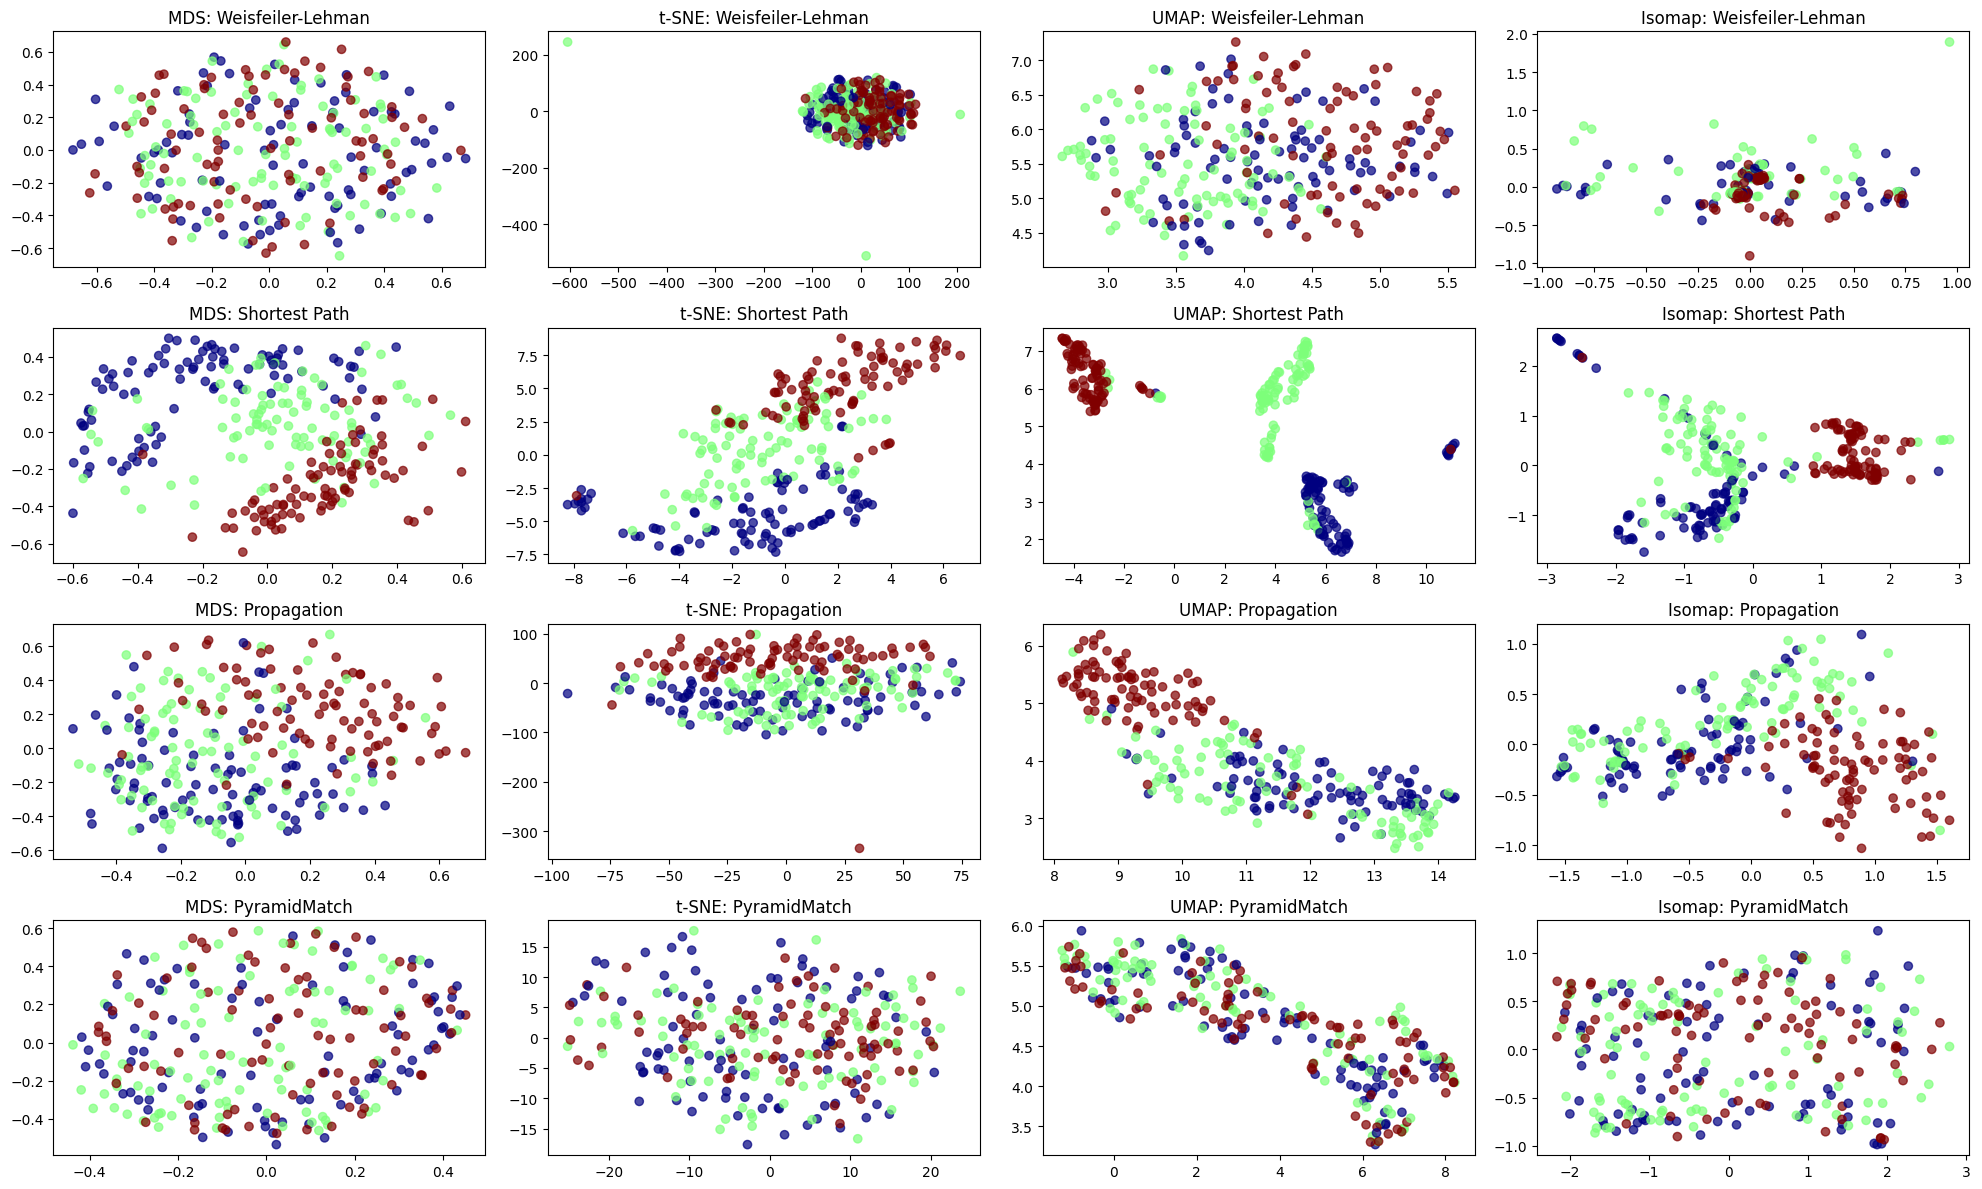

In [120]:
show('sqrt')

/mnt/c/Users/danie/Documents/Programming/DL_HSE/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/mnt/c/Users/danie/Documents/Programming/DL_HSE/.venv/lib/python3.12/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/mnt/c/Users/danie/Documents/Programming/DL_HSE/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/mnt/c/Users/danie/Documents/Programming/DL_HSE/.venv/lib/python3.12/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/mnt/c/Users/dan

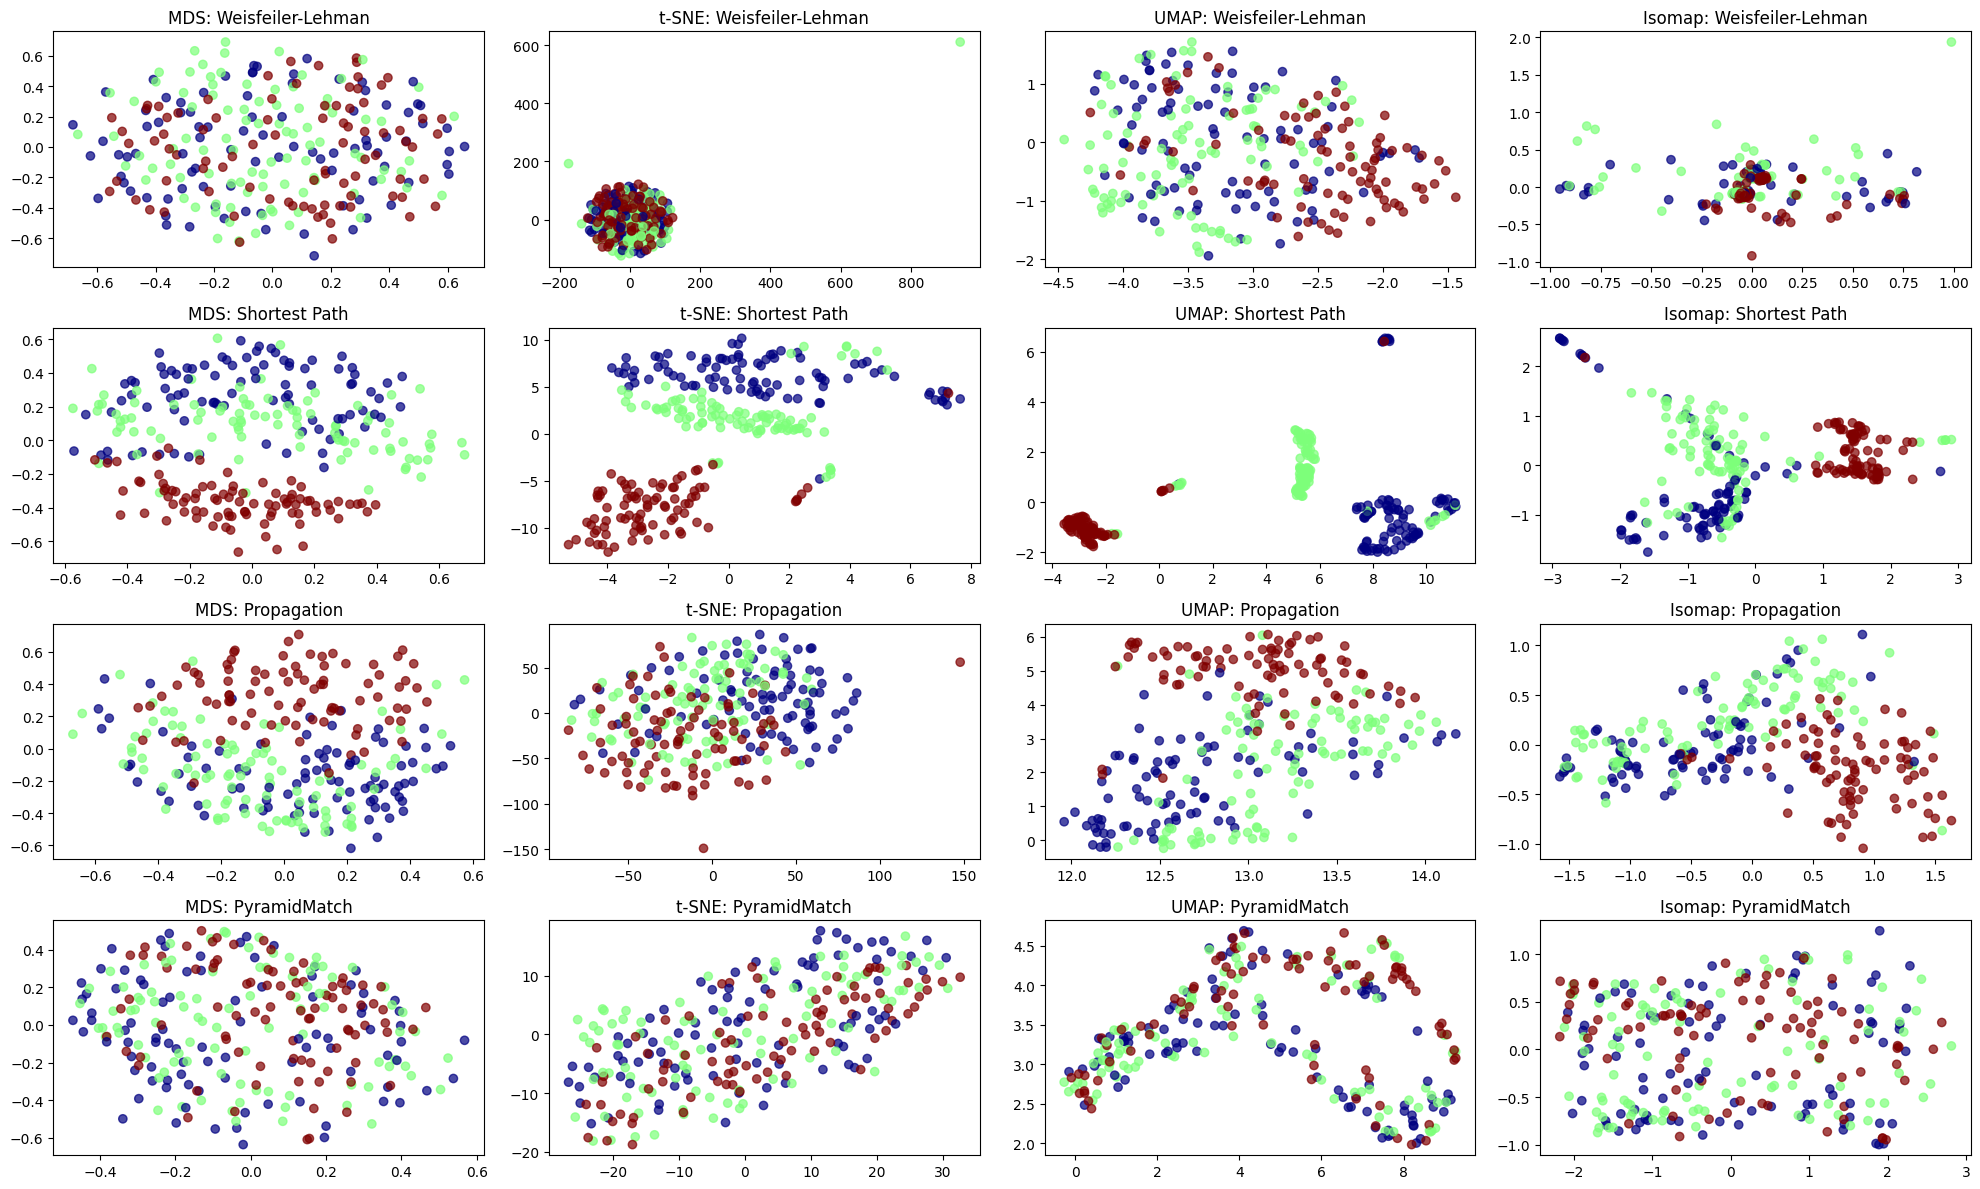

In [121]:
show('acos')

/mnt/c/Users/danie/Documents/Programming/DL_HSE/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/mnt/c/Users/danie/Documents/Programming/DL_HSE/.venv/lib/python3.12/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/mnt/c/Users/danie/Documents/Programming/DL_HSE/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/mnt/c/Users/danie/Documents/Programming/DL_HSE/.venv/lib/python3.12/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/mnt/c/Users/dan

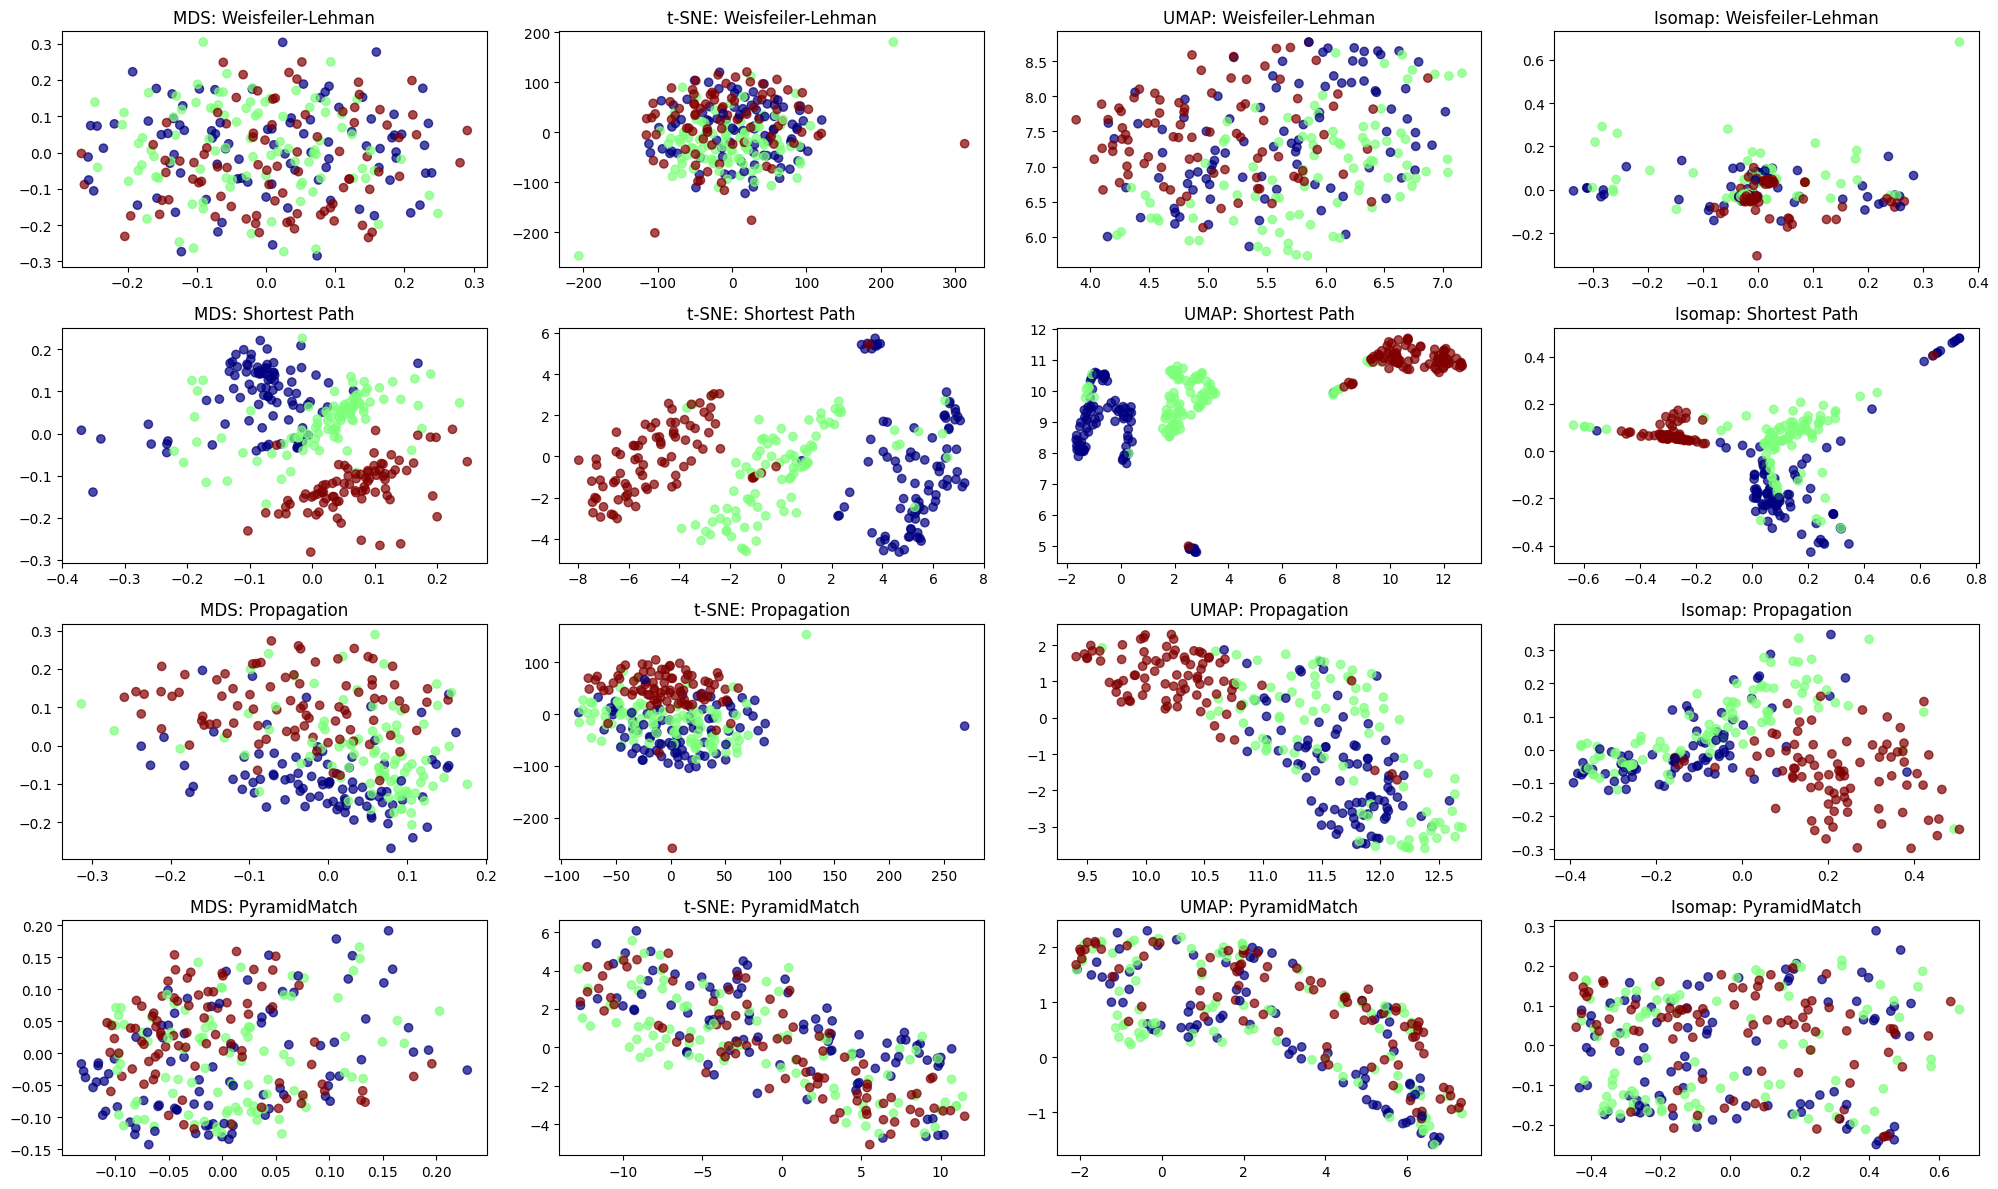

In [122]:
show('inverse')

/mnt/c/Users/danie/Documents/Programming/DL_HSE/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/mnt/c/Users/danie/Documents/Programming/DL_HSE/.venv/lib/python3.12/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/mnt/c/Users/danie/Documents/Programming/DL_HSE/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/mnt/c/Users/danie/Documents/Programming/DL_HSE/.venv/lib/python3.12/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/mnt/c/Users/dan

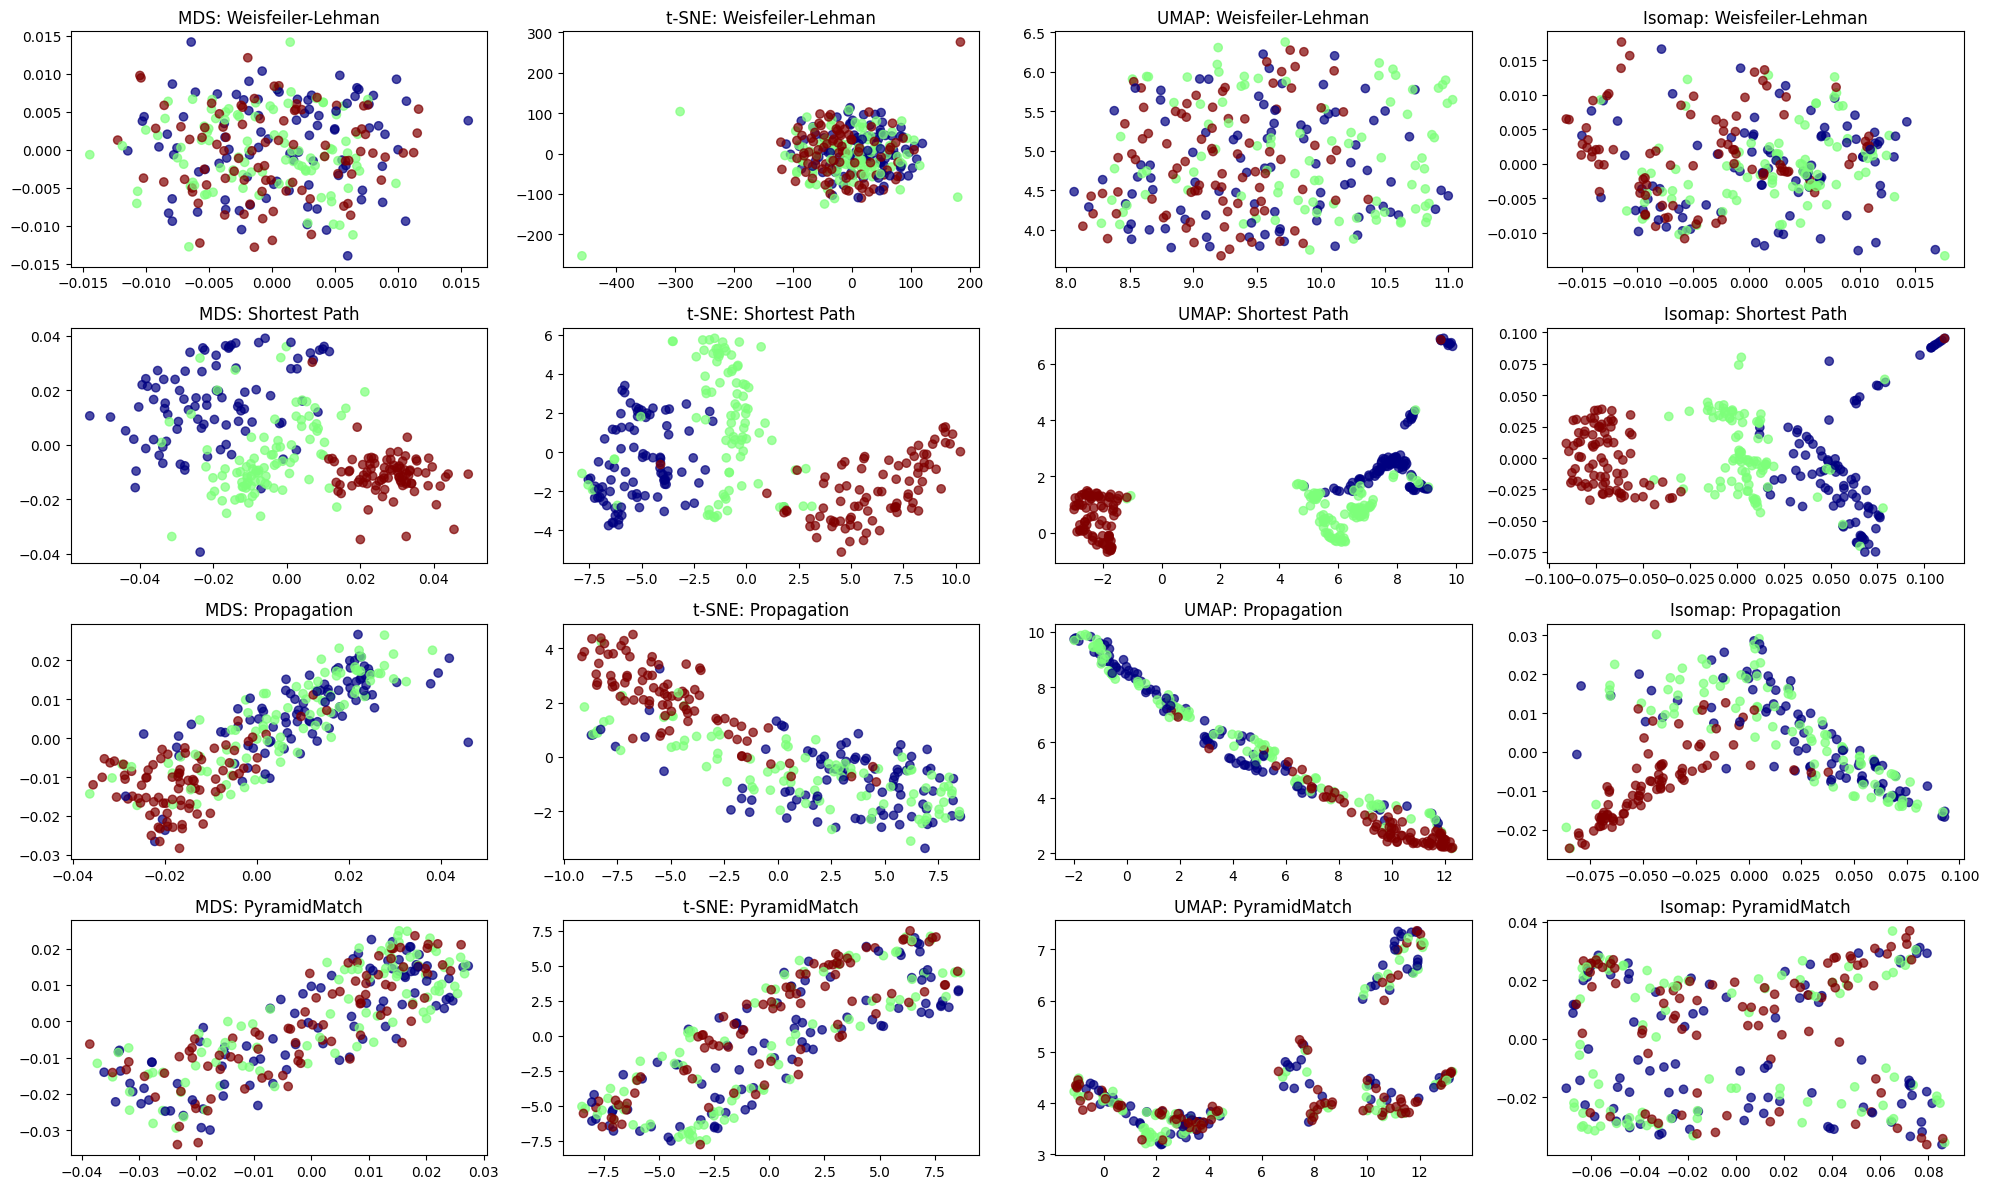

In [123]:
show('jsd')

Видим, что среди всех ядер, Shortest path наиболее убедительный, наиобее выраженная кластеризация у: UMAP-sqrt, UMAP-inverse, tSNE-acos и isomap-jsd

Теперь обучим модели: переберём модели для выбранных 4-ёх функций эмбединга и потюним их параметры.

In [129]:
G_f, y_f = load_dataset('hard')

kernel_f = ShortestPath(normalize=True)
ker_mat_f = kernel_f.fit_transform(G_f)

dist_mat_f_sqrt = compute_distance_matrix(ker_mat_f, 'sqrt')
dist_mat_f_inverse = compute_distance_matrix(ker_mat_f, 'inverse')
dist_mat_f_acos = compute_distance_matrix(ker_mat_f, 'acos')
dist_mat_f_jsd = compute_distance_matrix(ker_mat_f, 'jsd')

embeddings = {}

umap_sqrt = umap.UMAP(n_components=3, metric="precomputed")
embeddings["umap_sqrt"] = umap_sqrt.fit_transform(dist_mat_f_sqrt)

umap_inverse = umap.UMAP(n_components=3, metric="precomputed")
embeddings["umap_inverse"] = umap_inverse.fit_transform(dist_mat_f_inverse)

tsne_acos = TSNE(n_components=3, metric="precomputed", init='random')
embeddings["tsne_acos"] = tsne_acos.fit_transform(dist_mat_f_acos)

isomap_jsd = Isomap(n_components=3, metric="precomputed")
embeddings["isomap_jsd"] = isomap_jsd.fit_transform(dist_mat_f_jsd)

/tmp/ipykernel_29595/3603791568.py:19: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  G = nx.from_scipy_sparse_matrix(a)
/tmp/ipykernel_29595/3603791568.py:27: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  G = nx.from_scipy_sparse_matrix(a)
/mnt/c/Users/danie/Documents/Programming/DL_HSE/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/mnt/c/Users/danie/Documents/Programming/DL_HSE/.venv/lib/python3.12/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/mnt/c/Users/danie/Documents/Programming/DL_HSE/.venv/lib/python3.

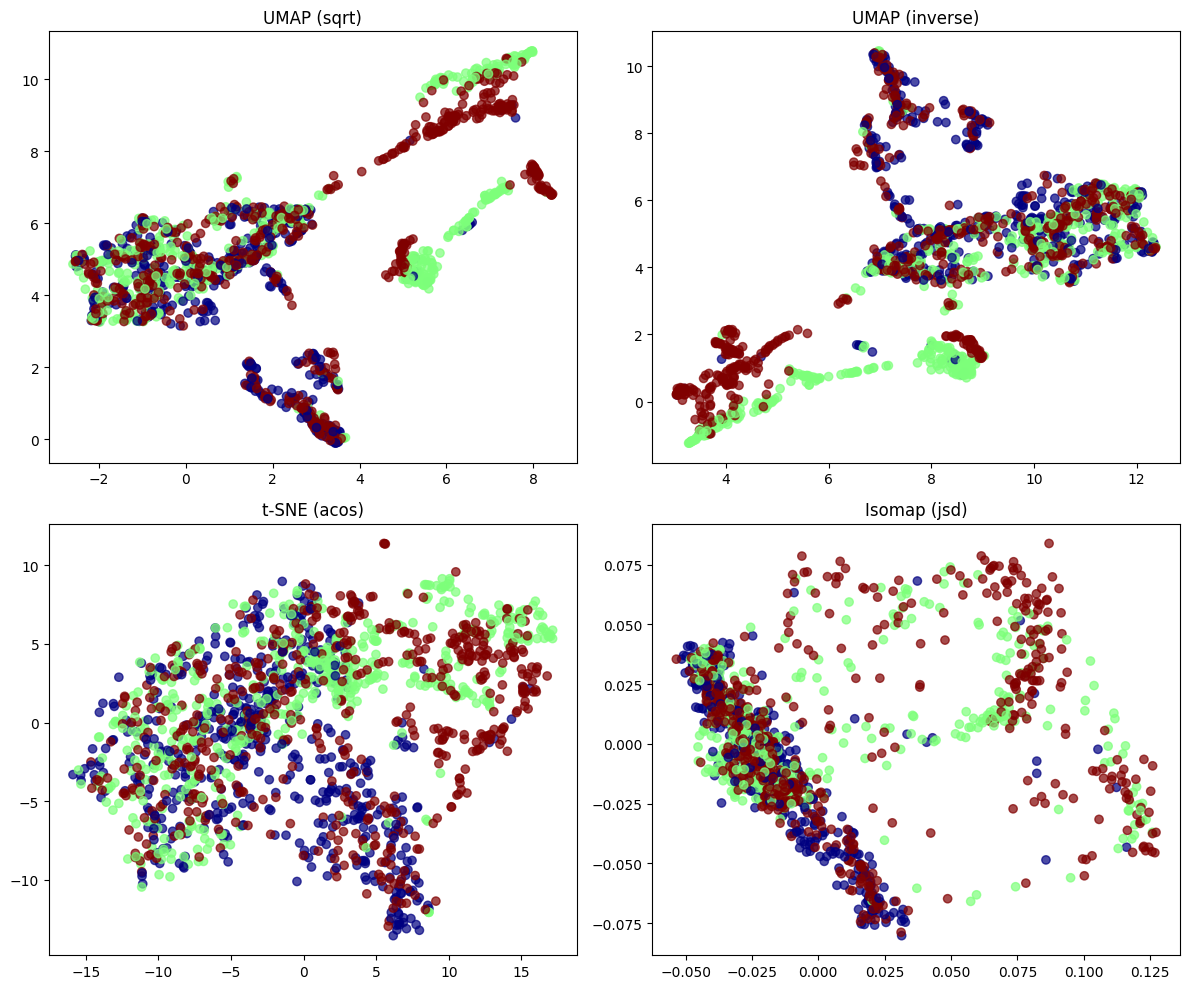

In [130]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
titles = ["UMAP (sqrt)", "UMAP (inverse)", "t-SNE (acos)", "Isomap (jsd)"]
embedding_keys = ["umap_sqrt", "umap_inverse", "tsne_acos", "isomap_jsd"]

for ax, key, title in zip(axes.flatten(), embedding_keys, titles):
    ax.scatter(embeddings[key][:, 0], embeddings[key][:, 1], c=y_f, cmap="jet", alpha=0.7)
    ax.set_title(title)

plt.tight_layout()
plt.show()

In [133]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

models = {
    "RandomForest": (RandomForestClassifier(), {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20]
    }),
    "SVM": (SVC(), {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    }),
    "KNN": (KNeighborsClassifier(), {
        'n_neighbors': [3, 5, 7]
    }),
    "LogisticRegression": (LogisticRegression(max_iter=1000), {
        'C': [0.1, 1, 10]
    }),
    "GradientBoosting": (GradientBoostingClassifier(), {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2]
    })
}

distance_matrices = {
    "sqrt": embeddings["umap_sqrt"],
    "inverse": embeddings["umap_inverse"],
    "acos": embeddings["tsne_acos"],
    "jsd": embeddings["isomap_jsd"]
}

In [135]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

best_models = {}
results_summary = {}

for name, X in distance_matrices.items():
    print(f"Training on {name} distance matrix...")

    X_train, X_test, y_train, y_test = train_test_split(X, y_f, test_size=0.2, random_state=42)

    best_model = None
    best_score = 0
    best_params = None
    best_name = None

    for model_name, (model, param_grid) in models.items():
        grid = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
        grid.fit(X_train, y_train)

        model_best = grid.best_estimator_
        y_pred = model_best.predict(X_test)
        acc = accuracy_score(y_test, y_pred)

        print(f"{model_name}: Accuracy = {acc:.4f} | Best Params = {grid.best_params_}")

        if acc > best_score:
            best_score = acc
            best_model = model_best
            best_params = grid.best_params_
            best_name = model_name

    best_models[name] = best_model
    results_summary[name] = {
        "Best Model": best_name,
        "Best Accuracy": best_score,
        "Best Parameters": best_params
    }


Training on sqrt distance matrix...
RandomForest: Accuracy = 0.6231 | Best Params = {'max_depth': 10, 'n_estimators': 50}
SVM: Accuracy = 0.5897 | Best Params = {'C': 10, 'kernel': 'rbf'}
KNN: Accuracy = 0.5623 | Best Params = {'n_neighbors': 5}
LogisticRegression: Accuracy = 0.5410 | Best Params = {'C': 1}
GradientBoosting: Accuracy = 0.6049 | Best Params = {'learning_rate': 0.1, 'n_estimators': 100}
Training on inverse distance matrix...
RandomForest: Accuracy = 0.6049 | Best Params = {'max_depth': 10, 'n_estimators': 100}
SVM: Accuracy = 0.5988 | Best Params = {'C': 10, 'kernel': 'rbf'}
KNN: Accuracy = 0.6018 | Best Params = {'n_neighbors': 5}
LogisticRegression: Accuracy = 0.5380 | Best Params = {'C': 0.1}
GradientBoosting: Accuracy = 0.6231 | Best Params = {'learning_rate': 0.1, 'n_estimators': 50}
Training on acos distance matrix...
RandomForest: Accuracy = 0.6687 | Best Params = {'max_depth': 20, 'n_estimators': 100}
SVM: Accuracy = 0.6201 | Best Params = {'C': 10, 'kernel': 'rb

In [136]:
results_summary

{'sqrt': {'Best Model': 'RandomForest',
  'Best Accuracy': 0.6231003039513677,
  'Best Parameters': {'max_depth': 10, 'n_estimators': 50}},
 'inverse': {'Best Model': 'GradientBoosting',
  'Best Accuracy': 0.6231003039513677,
  'Best Parameters': {'learning_rate': 0.1, 'n_estimators': 50}},
 'acos': {'Best Model': 'RandomForest',
  'Best Accuracy': 0.668693009118541,
  'Best Parameters': {'max_depth': 20, 'n_estimators': 100}},
 'jsd': {'Best Model': 'RandomForest',
  'Best Accuracy': 0.5167173252279635,
  'Best Parameters': {'max_depth': 10, 'n_estimators': 200}}}

Easy small:


{'sqrt': {'Best Model': 'RandomForest',
  'Best Accuracy': 0.9629629629629629,
  'Best Parameters': {'max_depth': 20, 'n_estimators': 200}},
 'inverse': {'Best Model': 'KNN',
  'Best Accuracy': 0.9629629629629629,
  'Best Parameters': {'n_neighbors': 3}},
 'acos': {'Best Model': 'RandomForest',
  'Best Accuracy': 0.9814814814814815,
  'Best Parameters': {'max_depth': None, 'n_estimators': 200}},
 'jsd': {'Best Model': 'SVM',
  'Best Accuracy': 0.9444444444444444,
  'Best Parameters': {'C': 10, 'kernel': 'rbf'}}}

Hard small:


{'sqrt': {'Best Model': 'KNN',
  'Best Accuracy': 0.6727272727272727,
  'Best Parameters': {'n_neighbors': 3}},
 'inverse': {'Best Model': 'KNN',
  'Best Accuracy': 0.6363636363636364,
  'Best Parameters': {'n_neighbors': 3}},
 'acos': {'Best Model': 'SVM',
  'Best Accuracy': 0.7272727272727273,
  'Best Parameters': {'C': 10, 'kernel': 'rbf'}},
 'jsd': {'Best Model': 'RandomForest',
  'Best Accuracy': 0.6727272727272727,
  'Best Parameters': {'max_depth': 10, 'n_estimators': 100}}}

Easy

{'sqrt': {'Best Model': 'GradientBoosting',
  'Best Accuracy': 0.9817073170731707,
  'Best Parameters': {'learning_rate': 0.01, 'n_estimators': 100}},
 'inverse': {'Best Model': 'GradientBoosting',
  'Best Accuracy': 0.9817073170731707,
  'Best Parameters': {'learning_rate': 0.01, 'n_estimators': 200}},
 'acos': {'Best Model': 'RandomForest',
  'Best Accuracy': 0.9817073170731707,
  'Best Parameters': {'max_depth': 10, 'n_estimators': 200}},
 'jsd': {'Best Model': 'SVM',
  'Best Accuracy': 0.9207317073170732,
  'Best Parameters': {'C': 10, 'kernel': 'rbf'}}}

Hard

{'sqrt': {'Best Model': 'RandomForest',
  'Best Accuracy': 0.6231003039513677,
  'Best Parameters': {'max_depth': 10, 'n_estimators': 50}},
 'inverse': {'Best Model': 'GradientBoosting',
  'Best Accuracy': 0.6231003039513677,
  'Best Parameters': {'learning_rate': 0.1, 'n_estimators': 50}},
 'acos': {'Best Model': 'RandomForest',
  'Best Accuracy': 0.668693009118541,
  'Best Parameters': {'max_depth': 20, 'n_estimators': 100}},
 'jsd': {'Best Model': 'RandomForest',
  'Best Accuracy': 0.5167173252279635,
  'Best Parameters': {'max_depth': 10, 'n_estimators': 200}}}

# Итого

* easy_small: 0.98148
* hard_small: 0.7272
* easy: 0.9817
* hard: 0.668693